#### Warm Up | Master's Thesis
# QST WITH A COMPLEX VALUED STATE


This is just some playing around with a quantum state having complex values. The code is basically the same as in the notebook `basic_qst.ipynb` stripped down to its basics.

The quantum state at hand is:

$$
|\psi_\rangle =
\frac{1}{4 \sqrt{2}}
\begin{bmatrix}
3 \\
-1 + i \\
2 \\
-2 \\
1 \\
0 \\
-2 - 2i \\
-2
\end{bmatrix}
$$

This state is a vector in an **8-dimensional Hilbert space**, corresponding to a **3-qubit system**.

In [35]:
import numpy as np

from collections import Counter
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
class PauliOperator:
    def __init__(self, matrix, eigenvalues, eigenvectors):
        """
        Bundles the relevant information of a Pauli operator into a single object.

        REMARK: The eigenvalues and eigenvectors are directly passed to avoid numerical inaccuracies.

        :param matrix: The matrix representation of the Pauli operator.
        :param eigenvalues: The eigenvalues of the Pauli operator.
        :param eigenvectors: The eigenvectors of the Pauli operator.
        """
        self.matrix = matrix
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors


class MultiQubitMeasurementSetting:
    def __init__(self, measurement_settings):
        """
        Represents a multi-qubit measurement setting using Pauli operators.

        :param measurement_settings: A list of Pauli operators representing the measurement setting for each qubit.
        """
        self._measurement_settings = measurement_settings
        self.eigenvectors = []
        self.eigenvalues = []

        self._construct_basis()

    def _construct_basis(self):
        """
        Constructs the multi-qubit basis vectors and their corresponding eigenvalues from the given Pauli operators.
        """

        # in this first loop we iterate over the computational basis states of the n-qubit system
        # constructing them as a list of 0s and 1s allows us to leverage pythons addressing capabilities
        for state_addressing in product(range(2), repeat=len(self._measurement_settings)):
            multi_qubit_eigenvalue = 1.0
            multi_qubit_eigenvector = None

            # we pair up the Pauli operator for each single qubit basis state and retrieve the matching eigenvalue and eigenvector
            for pauli_op, state_index in zip(self._measurement_settings, state_addressing):
                eigenvalue = pauli_op.eigenvalues[state_index]
                eigenvector = pauli_op.eigenvectors[state_index]

                # the eigenvalue of the multi-qubit operator is the product of the single-qubit eigenvalues
                multi_qubit_eigenvalue *= eigenvalue

                # we build up the multi-qubit eigenvector by taking the tensor product of the single-qubit eigenvectors
                if multi_qubit_eigenvector is None:
                    multi_qubit_eigenvector = eigenvector
                else:
                    multi_qubit_eigenvector = np.kron(multi_qubit_eigenvector, eigenvector)

            self.eigenvalues.append(multi_qubit_eigenvalue)
            self.eigenvectors.append(multi_qubit_eigenvector)

In [37]:
sigma_0 = PauliOperator(np.eye(2), [1, 1], [np.array([1, 0]), np.array([0, 1])])
sigma_x = PauliOperator(np.array([[0, 1], [1, 0]]), [1, -1], [np.array([1, 1]) / np.sqrt(2), np.array([1, -1]) / np.sqrt(2)])
sigma_y = PauliOperator(np.array([[0, -1j], [1j, 0]]), [1, -1], [np.array([1, -1j]) / np.sqrt(2), np.array([1, 1j]) / np.sqrt(2)])
sigma_z = PauliOperator(np.array([[1, 0], [0, -1]]), [1, -1], [np.array([1, 0]), np.array([0, 1])])
pauli_operators = { 'I': sigma_0, 'X': sigma_x, 'Y': sigma_y, 'Z': sigma_z }


def sample_state(state, pauli_labels, num_samples=1000):
    measurement_settings = [pauli_operators[pl] for pl in pauli_labels]
    multi_qubit_meas_setting = MultiQubitMeasurementSetting(measurement_settings)

    probs = [np.abs(np.dot(vec, state))**2 for vec in multi_qubit_meas_setting.eigenvectors]

    theo_exp = sum(e * p for e, p in zip(multi_qubit_meas_setting.eigenvalues, probs))

    outcomes = np.random.choice(range(len(state)), size=num_samples, p=probs)
    counts = Counter(outcomes)

    obs_exp = 0
    for state_idx, count_value in counts.items():
        obs_exp += multi_qubit_meas_setting.eigenvalues[state_idx] * (count_value / num_samples)

    return theo_exp, obs_exp

In [38]:
# let's use the complex state from above and reconstruct its density matrix

psi = (1 / (4 * np.sqrt(2))) * np.array([3, -1 + 1j, 2, -2, 1, 0, -2 - 2j, -2], dtype=complex)
num_samples = 1000

pauli_label_combinations = list(product(['I', 'X', 'Y', 'Z'], repeat=3))

print("Performing measurements for all settings...")
theo_exp_dict = {}
obs_exp_dict = {}

for pauli_labels in pauli_label_combinations:
    theo_exp, obs_exp = sample_state(psi, pauli_labels, num_samples=num_samples)
    theo_exp_dict[pauli_labels] = theo_exp
    obs_exp_dict[pauli_labels] = obs_exp

print("Measurements completed.")

Performing measurements for all settings...
Measurements completed.


In [39]:
rho_reconstructed = np.zeros((8, 8), dtype=complex)
for pauli_labels in obs_exp_dict:
    sigma_i = pauli_operators[pauli_labels[0]].matrix
    sigma_j = pauli_operators[pauli_labels[1]].matrix
    sigma_k = pauli_operators[pauli_labels[2]].matrix

    multi_qubit_bloch_basis = np.kron(sigma_i, np.kron(sigma_j, sigma_k))

    rho_reconstructed += obs_exp_dict[pauli_labels] * multi_qubit_bloch_basis / 8.0

In [40]:
rho_actual = np.outer(psi, psi.conj())

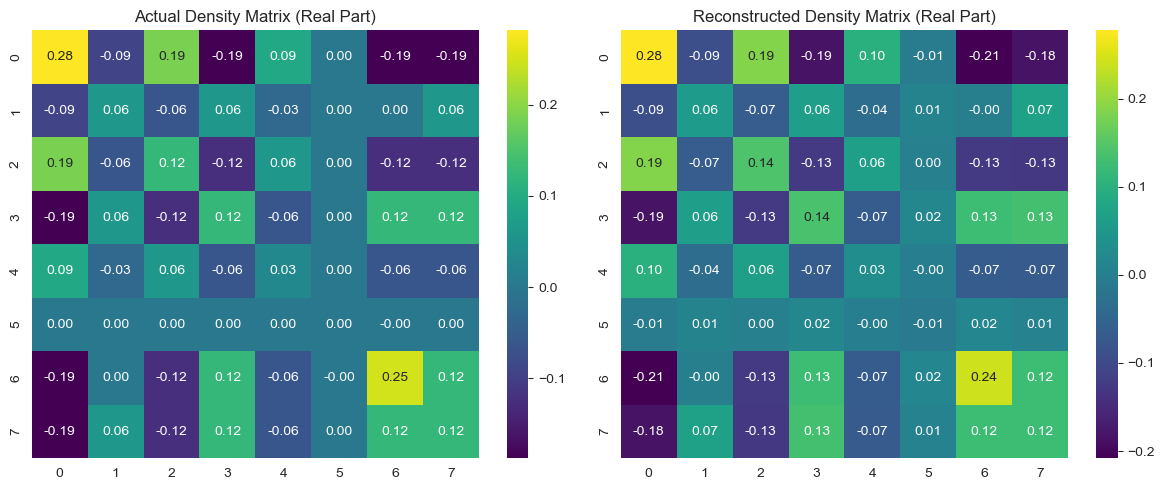

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(np.real(rho_actual), annot=True, fmt=".2f", ax=axes[0], cmap='viridis')
axes[0].set_title('Actual Density Matrix (Real Part)')

sns.heatmap(np.real(rho_reconstructed), annot=True, fmt=".2f", ax=axes[1], cmap='viridis')
axes[1].set_title('Reconstructed Density Matrix (Real Part)')

plt.tight_layout()
plt.show()

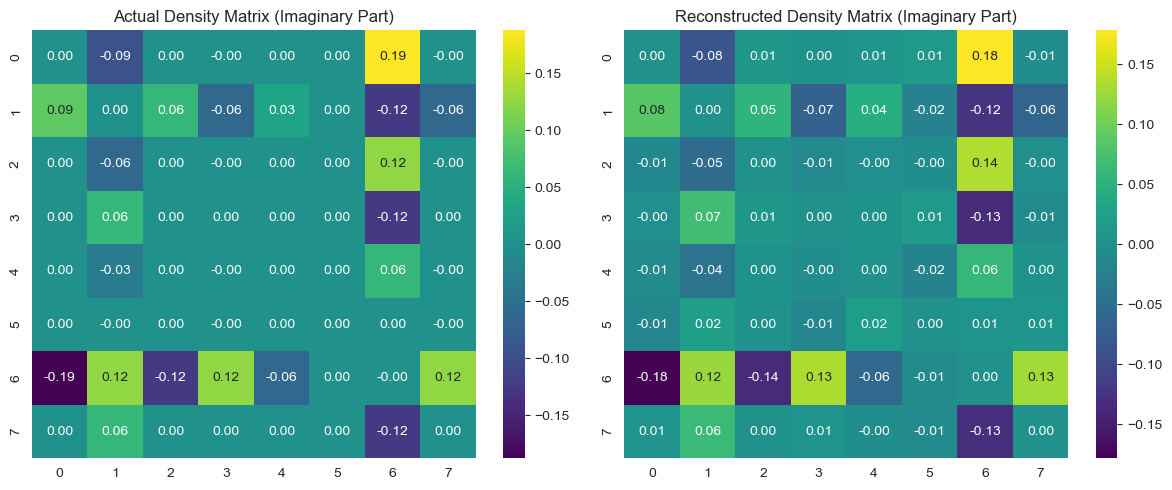

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(np.imag(rho_actual), annot=True, fmt=".2f", ax=axes[0], cmap='viridis')
axes[0].set_title('Actual Density Matrix (Imaginary Part)')

sns.heatmap(np.imag(rho_reconstructed), annot=True, fmt=".2f", ax=axes[1], cmap='viridis')
axes[1].set_title('Reconstructed Density Matrix (Imaginary Part)')

plt.tight_layout()
plt.show()